In [23]:
import os # File system operations
import re # Regular expressions
import pandas as pd # Tabular data
import numpy as np # Numerical data
pd.set_option('display.max_colwidth', None) # Show full file paths

# Don't use all of the GPU RAM
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow import keras # ML

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from pathlib import Path
from glob import glob
import matplotlib.pyplot as plt # Plotting
import seaborn as sns # Plotting
sns.set()
from tqdm.auto import tqdm # Progress bars

BASE_DIR = Path("/home/nick/dbox/EmbryoLabeling/Labelers/train")
folders = os.listdir(BASE_DIR)
folders = [f for f in folders if not re.match(r"M\d", f)]
files = []
for folder in folders:
    files_in_folder = pd.DataFrame(glob(f"{BASE_DIR}/{folder}/**/*.jpg", recursive=True), columns=["filename"])
    files_in_folder["class"] = folder
    files.append(files_in_folder)
df = pd.concat(files)
df["class"].value_counts()

Morula                 1319
2pn                    1039
Syngamy                 834
4 Cell                  792
2 Cell                  736
Compacting 8 cell       549
Expanded Blastocyst     394
8 Cell                  384
Blastocyst              374
6 Cell                  360
Cavitating morula       324
3 Cell                  303
Early blast             291
Name: class, dtype: int64

<AxesSubplot:>

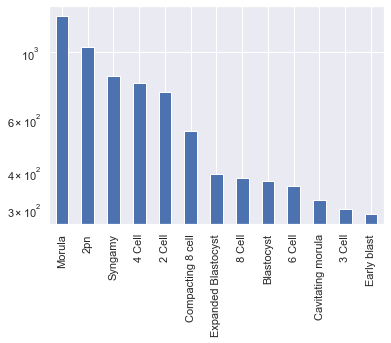

In [24]:
df["class"].value_counts().plot.bar(logy=True)

In [25]:
pd.set_option('display.max_rows', 365)
M776_S0087_W2 = df[df.filename.str.contains("M776_S0087_W2")].copy()
M776_S0087_W2["time_since_fert"] = M776_S0087_W2.filename.apply(lambda s: s.replace(".jpg", "").split("_")[-1]).astype(int)
M776_S0087_W2 = M776_S0087_W2.sort_values(by="time_since_fert")
M776_S0087_W2 = M776_S0087_W2.groupby("class").head(1)
print(M776_S0087_W2[["class", "time_since_fert"]])

                 class  time_since_fert
315                2pn             1061
537            Syngamy             1464
297             2 Cell             1574
179             3 Cell             2315
182             4 Cell             2395
346             6 Cell             3125
136             8 Cell             3265
370  Compacting 8 cell             3375
24              Morula             4286
158  Cavitating morula             5940
32         Early blast             6090
5           Blastocyst             6261


In [26]:
classes = list(M776_S0087_W2["class"])
classes

['2pn',
 'Syngamy',
 '2 Cell',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Compacting 8 cell',
 'Morula',
 'Cavitating morula',
 'Early blast',
 'Blastocyst']

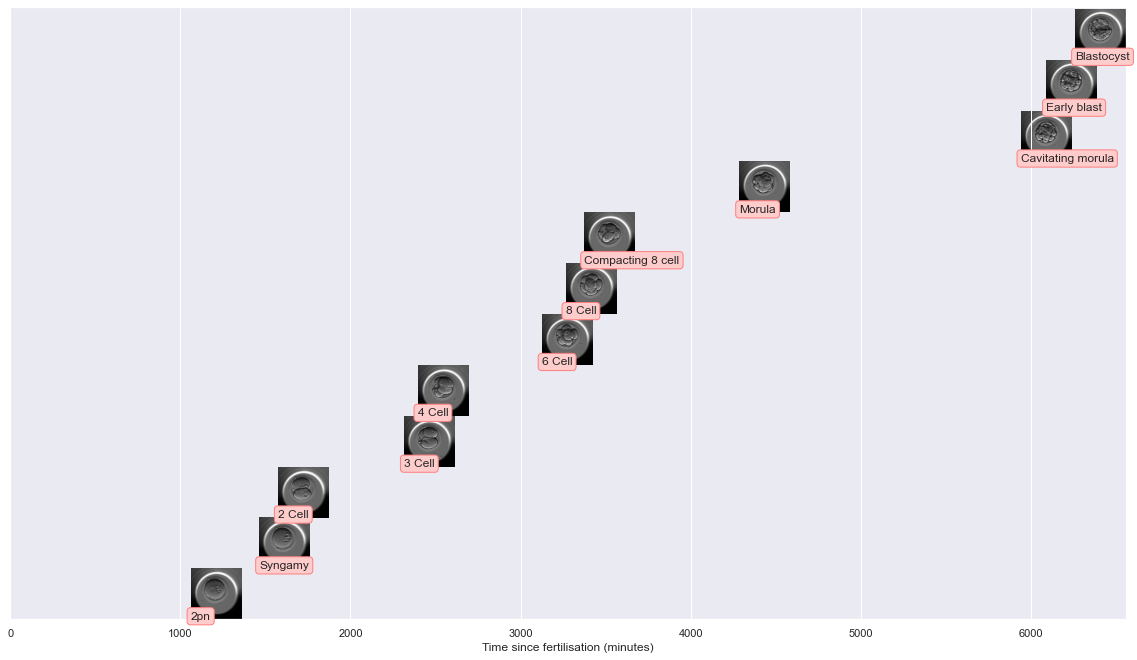

In [27]:
plt.figure(figsize=(20, 20))
for i, row in M776_S0087_W2.iterrows():
    image = keras.utils.load_img(row.filename, target_size=(299,299))
    c_index = classes.index(row["class"]) * 299
    time_since_fert = row.time_since_fert
    plt.imshow(image, extent=[time_since_fert, time_since_fert+299, c_index, c_index+299])
    plt.text(time_since_fert, c_index, row["class"], bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))
plt.yticks([])
plt.xlabel("Time since fertilisation (minutes)")
plt.xlim(0, M776_S0087_W2.time_since_fert.max() + 300)
plt.ylim(0, len(classes) * 300)
plt.show()

In [28]:
class_counts = df["class"].value_counts()
mask = ~df["class"].isin(class_counts[class_counts > 10].index)
#df["class"][mask] = "Other"

In [29]:
#df["class"][~df["class"].isin(["Empty", "Morula"])] = "Other"
train_rows = []
validation_rows = []
for c in df["class"].unique():
    df_for_class = df[df["class"] == c].copy()
    if len(df_for_class) > 20:
        validation_sample = df_for_class.sample(round(.2*len(df_for_class)))
        validation_rows.append(validation_sample)
        train_sample = df_for_class.drop(validation_sample.index)
        # Accounting for training class imbalance
        train_sample = train_sample.sample(min(len(train_sample), round(.6*len(df_for_class)))) # still leaving 20%. Might need more sophisticated f(x) here for class imbalance.
        train_rows.append(train_sample)
train_df = pd.concat(train_rows)
validation_df = pd.concat(validation_rows)
display(df)
display(train_df["class"].value_counts())
validation_df = validation_df.sample(frac=1)
display(validation_df["class"].value_counts())

,filename,class
0,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00534_W4_F0_1676.jpg,3 Cell
1,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00635_W1_F0_2951.jpg,3 Cell
2,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00761_W6_F0_2158.jpg,3 Cell
3,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00635_W10_F0_2215.jpg,3 Cell
4,/home/nick/dbox/EmbryoLabeling/Labelers/train/3 Cell/M0776_S00512_W7_F0_1670.jpg,3 Cell
...,...,...
286,/home/nick/dbox/EmbryoLabeling/Labelers/train/Early blast/M0776_S00512_W4_F0_6281.jpg,Early blast
287,/home/nick/dbox/EmbryoLabeling/Labelers/train/Early blast/M0776_S00761_W2_F0_5700.jpg,Early blast
288,/home/nick/dbox/EmbryoLabeling/Labelers/train/Early blast/M0776_S00635_W3_F0_6651.jpg,Early blast
289,/home/nick/dbox/EmbryoLabeling/Labelers/train/Early blast/M0776_S00512_W1_F0_5820.jpg,Early blast


Morula                 791
2pn                    623
Syngamy                500
4 Cell                 475
2 Cell                 442
Compacting 8 cell      329
Expanded Blastocyst    236
8 Cell                 230
Blastocyst             224
6 Cell                 216
Cavitating morula      194
3 Cell                 182
Early blast            175
Name: class, dtype: int64

Morula                 264
2pn                    208
Syngamy                167
4 Cell                 158
2 Cell                 147
Compacting 8 cell      110
Expanded Blastocyst     79
8 Cell                  77
Blastocyst              75
6 Cell                  72
Cavitating morula       65
3 Cell                  61
Early blast             58
Name: class, dtype: int64

In [30]:
datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
training = datagen.flow_from_dataframe(train_df, target_size=(299, 299), batch_size=24, shuffle=True)
# Don't shuffle validation, otherwise confusion_matrix won't work due to mismatch
validation = datagen.flow_from_dataframe(validation_df, target_size=(299, 299), batch_size=24, shuffle=False)

Found 4617 validated image filenames belonging to 13 classes.
Found 1541 validated image filenames belonging to 13 classes.


In [31]:
assert training.class_indices == validation.class_indices

In [32]:
list(training.class_indices.keys())

['2 Cell',
 '2pn',
 '3 Cell',
 '4 Cell',
 '6 Cell',
 '8 Cell',
 'Blastocyst',
 'Cavitating morula',
 'Compacting 8 cell',
 'Early blast',
 'Expanded Blastocyst',
 'Morula',
 'Syngamy']

In [33]:
code2class = {v:k for k, v in training.class_indices.items()}
code2class

{0: '2 Cell',
 1: '2pn',
 2: '3 Cell',
 3: '4 Cell',
 4: '6 Cell',
 5: '8 Cell',
 6: 'Blastocyst',
 7: 'Cavitating morula',
 8: 'Compacting 8 cell',
 9: 'Early blast',
 10: 'Expanded Blastocyst',
 11: 'Morula',
 12: 'Syngamy'}

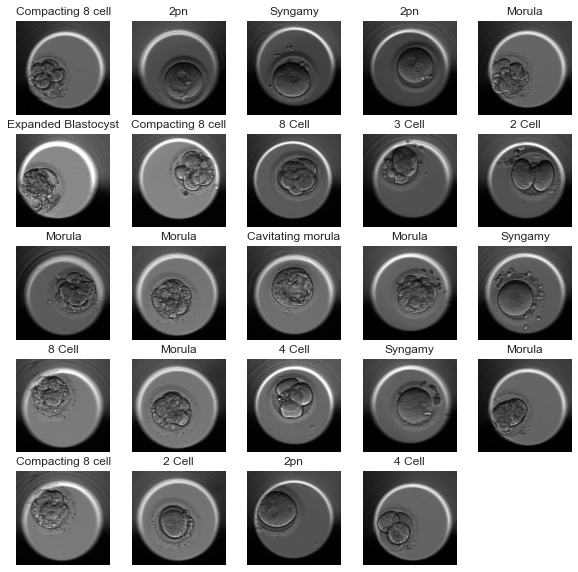

In [34]:
plt.figure(figsize=(10, 10))
images, labels = next(training)
for i in range(24):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

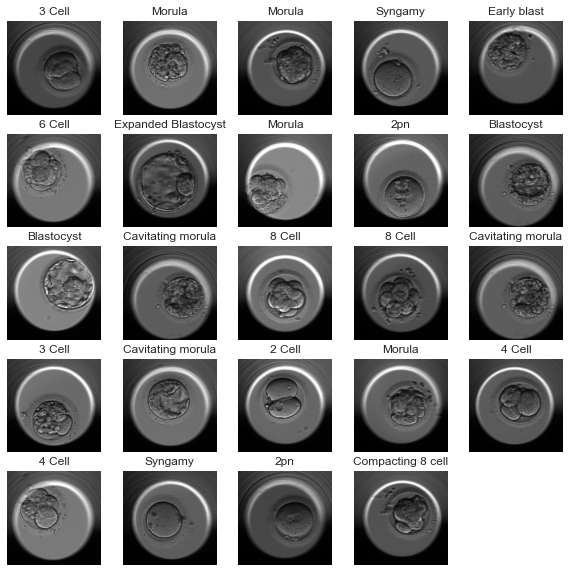

In [35]:
plt.figure(figsize=(10, 10))
images, labels = next(validation)
for i in range(min(24, len(labels))):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(code2class[labels[i].argmax()])
    plt.axis("off")

In [36]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=2, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
#x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(len(code2class), activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 13)                26637     
                                                                 
Total params: 20,888,117
Trainable params: 26,637
Non-trainable params: 20,861,480
__________________________________________

In [37]:
%%time
training.reset()
validation.reset()
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

history = model.fit(training, epochs=50, validation_data=validation)

Epoch 1/50
193/193 [==============================] - 25s 119ms/step - loss: 1.7128 - categorical_accuracy: 0.4663 - val_loss: 1.2960 - val_categorical_accuracy: 0.6022
Epoch 2/50
193/193 [==============================] - 22s 115ms/step - loss: 1.1755 - categorical_accuracy: 0.6350 - val_loss: 1.0403 - val_categorical_accuracy: 0.6872
Epoch 3/50
193/193 [==============================] - ETA: 0s - loss: 0.9823 - categorical_accuracy: 0.6989

KeyboardInterrupt: 

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()

In [ ]:
validation.reset()
print("True:", validation.labels)
print("Predictions: ", model.predict(validation).argmax(axis=1))

In [ ]:
validation.reset()
y_pred = model.predict(validation).argmax(axis=1)
print(classification_report(validation.labels, y_pred))
labels = list(training.class_indices.keys())
s = sns.heatmap(confusion_matrix(validation.labels, y_pred), annot=True, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)

In [ ]:
model.save(f"models/{len(code2class)}_class.h5")